In [2]:
import pandas as pd
import seaborn as sns

from Levenshtein import distance
from tqdm import tqdm

from multiprocessing import Pool
from glob import glob

# Overview 
Training data
- waltzDB


Test data
- Serrano
- AmyPro

There can't be *any* overlap (i.e. exact sequence match) between the train and test sets. Overlap between the test sets is discouraged, but not strictly disallowed

# Load data

In [2]:
path = '../../../sbxw_files/cleaned_datasets/waltzdb.csv'
waltz_df = pd.read_csv(path,index_col=0)
waltz_df = waltz_df.drop(columns='data_split')
waltz_df

,sequence,value_bool,dataset
0,STVPIE,False,waltzdb
1,GVIWIA,True,waltzdb
2,LATVYA,False,waltzdb
3,NATAHQ,False,waltzdb
4,STVGIE,False,waltzdb
...,...,...,...
1394,VNNNNN,False,waltzdb
1395,EEKKEE,False,waltzdb
1396,EKKEEK,False,waltzdb
1397,KKEEEK,False,waltzdb


In [3]:
path = '../../../sbxw_files/cleaned_datasets/serrano.csv'
serrano_df = pd.read_csv(path,index_col=0)
serrano_df = serrano_df.drop(columns=['parent_protein','name','tango_pred','pH']).reset_index(drop=True)
serrano_df.dataset = serrano_df.dataset.replace({'cleaned_S1_41587_2004_BFnbt1012_MOESM2_ESM':'serrano_s1',
                                                 'cleaned_S2_41587_2004_BFnbt1012_MOESM3_ESM':'serrano_s2'})
serrano_df = serrano_df.rename(columns={'exp_aggregation':'value_bool'})
serrano_df = serrano_df.drop(columns=['data_split'])
serrano_df['sequence_length'] = serrano_df['sequence'].apply(len)
serrano_df

,sequence,value_bool,dataset,sequence_length
0,PGGGKVQIVYKPV,1,serrano_s1,13
1,PGGGKVYKPV,0,serrano_s1,10
2,PGGGKNAEVYKPV,0,serrano_s1,13
3,PGGGKVQIVEKPV,0,serrano_s1,13
4,QTAPVPMPDLKNVKSKIGSTENLKHQPGGGKVQIVY,0,serrano_s1,36
...,...,...,...,...
243,YLLYYTEFTP,1,serrano_s2,10
244,TEFTPTEKDE,1,serrano_s2,10
245,TEKDEYACRV,0,serrano_s2,10
246,YACRVNHVTL,0,serrano_s2,10


In [4]:
serrano_df.groupby('sequence_length').size()

sequence_length
4      1
5      4
6      7
7      7
8     11
9     13
10    78
11     5
12     6
13    11
14     1
15    18
16    15
17     9
18    13
19     9
20    10
21     8
22     4
23     3
24     2
25     3
26     1
27     2
28     1
30     1
31     1
36     2
40     1
43     1
dtype: int64

In [3]:
path = '../../tables/250211_amypro27.csv'
amypro_df = pd.read_csv(path,index_col=0)
amypro_df = amypro_df.drop(columns=['data_split','mask']) 
amypro_df

,name,sequence,res_value_bool,dataset,value_bool,len
0,Prolactin__AP00001,LPICPGGAARCQVTLRDLFDRAVVLSHYIHNLSSEMFSEFDKRYTH...,0000001111111111111111111111111111000000001111...,amypro27,1,199
1,Alpha-s2-casein__AP00004,KNTMEHVSSSEESIISQETYKQEKNMAINPSKENLCSTFCKEVVRN...,0000000000000000000000000000000000000000000000...,amypro27,1,207
2,Serum_Amyloid_A-1__AP00005,RSFFSFLGEAFDGARDMWRAYSDMREANYIGSDKYFHARGNYDAAK...,1111111111111111111111111110000000000000000000...,amypro27,1,104
3,Medin__AP00018,RLDKQGNFNAWVAGSYGNDQWLQVDLGSSKEVTGIITQGARNFGSV...,0000000000000000000000000000000111111111111111...,amypro27,1,50
4,Apoliprotein__AP00020,TQQPQQDEMPSPTFLTQVKESLSSYWESAKTAAQNLYEKTYLPAVD...,0000000000000000000000000000000000000000000000...,amypro27,1,79
5,Odontogenic_ameloblast-associated_protein__AP...,APLIPQRLMSASNSNELLLNLNNGQLLPLQLQGPLNSWIPPFSGIL...,0000000000000000000000000000000000000000000000...,amypro27,1,264
6,Beta-lactoglobulin__AP00025,LIVTQTMKGLDIQKVAGTWYSLAMAASDISLLDAQSAPLRVYVEEL...,0000000000111111111100000000000000000000000000...,amypro27,1,162
7,Apomyoglobin__AP00030,GLSDGEWQQVLNVWGKVEADIAGHGQEVLIRLFTGHPETLEKFDKF...,1111111111111111111111111111100000000000000000...,amypro27,1,153
8,Chaplin_H__AP00039,DSGAQGAAVHSPGVLSGNVVQVPVHVPVNVCGNTISVIGLLNPAFG...,0000000000001111111111111111100111111111111111...,amypro27,1,52
9,Microcin_E492__AP00040,GETDPNTQLLNDLGNNMAWGAALGAPGGLGSAALGAAGGALQTVGQ...,0000000000000000000000000000000000000000000000...,amypro27,1,84


# Compare

In [6]:
def kmerize(seq,k=6):
    for i in range(len(seq)-k+1):
        yield seq[i:i+k]


In [7]:
[x for x in kmerize('PGGGKVQIVEKPV')]

['PGGGKV',
 'GGGKVQ',
 'GGKVQI',
 'GKVQIV',
 'KVQIVE',
 'VQIVEK',
 'QIVEKP',
 'IVEKPV']

In [8]:
[x for x in kmerize('KPVKPV')] # if shorter than 6, will not return anything

['KPVKPV']

In [9]:
[x for x in kmerize('KPV')] # if shorter than 6, will not return anything

[]

In [10]:
test = [[1,2,3],[4,5,6]]
[y for x in test for y in x]

[1, 2, 3, 4, 5, 6]

In [11]:
def compare_kmers(i,row,j,kmer,k,waltz_row):
    row_copy = row.copy(deep=True)
    row_copy['index'] = i
    row_copy['kmer_index'] = j
    row_copy['kmer_seq'] = kmer
    row_copy['waltz_index'] = k
    row_copy['waltz_seq'] = waltz_row['sequence']
    row_copy['distance'] = distance(kmer,waltz_row['sequence'])
    return row_copy

In [12]:
kmer_length = 6
for i,row in tqdm(serrano_df.iterrows()):
    args = [(i,row,j,kmer,k,waltz_row) for j,kmer in enumerate(kmerize(row['sequence'],kmer_length)) for k,waltz_row in waltz_df.iterrows()]
    with Pool() as p:
        row_list = p.starmap(compare_kmers,args)
    batch_df = pd.DataFrame(row_list)
    batch_df.to_csv(f'comparison_tables/serrano_batches/batch_{i}.csv')

248it [13:18,  3.22s/it]


In [17]:
s_overlap_df = pd.concat(pd.read_csv(x,index_col=0) for x in glob('comparison_tables/serrano_batches/batch_*.csv'))
s_overlap_df = s_overlap_df.sort_values(by=['index','kmer_index','waltz_index'])
s_overlap_df.to_csv('comparison_tables/serrano_vs_waltz_kmers.csv')

In [18]:
s_overlap_df = pd.read_csv('comparison_tables/serrano_vs_waltz_kmers.csv')
s_overlap_df = s_overlap_df.drop(columns='Unnamed: 0')
s_overlap_df[s_overlap_df['distance']==0].to_csv('comparison_tables/serrano_vs_waltz_kmers_distance0.csv')
s_overlap_df

,sequence,value_bool,dataset,sequence_length,index,kmer_index,kmer_seq,waltz_index,waltz_seq,distance
0,PGGGKVQIVYKPV,1,serrano_s1,13,0,0,PGGGKV,0,STVPIE,6
1,PGGGKVQIVYKPV,1,serrano_s1,13,0,0,PGGGKV,1,GVIWIA,6
2,PGGGKVQIVYKPV,1,serrano_s1,13,0,0,PGGGKV,2,LATVYA,6
3,PGGGKVQIVYKPV,1,serrano_s1,13,0,0,PGGGKV,3,NATAHQ,6
4,PGGGKVQIVYKPV,1,serrano_s1,13,0,0,PGGGKV,4,STVGIE,5
...,...,...,...,...,...,...,...,...,...,...
3056810,NHVTLSQPKI,0,serrano_s2,10,247,4,LSQPKI,1394,VNNNNN,6
3056811,NHVTLSQPKI,0,serrano_s2,10,247,4,LSQPKI,1395,EEKKEE,6
3056812,NHVTLSQPKI,0,serrano_s2,10,247,4,LSQPKI,1396,EKKEEK,6
3056813,NHVTLSQPKI,0,serrano_s2,10,247,4,LSQPKI,1397,KKEEEK,6


In [12]:
def compare_kmers(i,row,j,kmer,k,waltz_row):
    # row_copy = row.copy(deep=True)
    row_copy = {
        'index':i,
        'kmer_index':j,
        'kmer_seq':kmer,
        'waltz_index':k,
        # 'waltz_seq':waltz_row['sequence'],
        'distance': distance(kmer,waltz_row['sequence'])
    }
    return pd.Series(row_copy)

In [13]:
kmer_length = 6
for i,row in tqdm(amypro_df.iterrows()):
    args = [(i,row,j,kmer,k,waltz_row) for j,kmer in enumerate(kmerize(row['sequence'],kmer_length)) for k,waltz_row in waltz_df.iterrows()]
    with Pool(8) as p:
        row_list = p.starmap(compare_kmers,args)
    batch_df = pd.DataFrame(row_list)
    batch_df.to_csv(f'comparison_tables/amypro_batches/batch_{i}.csv')

27it [30:09, 67.01s/it] 


In [14]:
a_overlap_df = pd.concat(pd.read_csv(x) for x in glob('comparison_tables/amypro_batches/batch_*.csv'))
a_overlap_df = a_overlap_df.sort_values(by=['index','kmer_index','waltz_index'])
a_overlap_df.to_csv('comparison_tables/amypro_vs_waltz_kmers.csv')

In [8]:
a_overlap_df = pd.read_csv('comparison_tables/amypro_vs_waltz_kmers.csv')
a_overlap_df = a_overlap_df.drop(columns=['Unnamed: 0','Unnamed: 0.1'])
a_overlap_df[a_overlap_df['distance']==0].to_csv('comparison_tables/amypro_vs_waltz_kmers_distance0.csv')
a_overlap_df

,index,kmer_index,kmer_seq,waltz_index,distance
0,0,0,LPICPG,0,6
1,0,0,LPICPG,1,5
2,0,0,LPICPG,2,5
3,0,0,LPICPG,3,6
4,0,0,LPICPG,4,6
...,...,...,...,...,...
6012897,26,130,DSVRIF,1394,6
6012898,26,130,DSVRIF,1395,6
6012899,26,130,DSVRIF,1396,6
6012900,26,130,DSVRIF,1397,6


# Analysis

## min distance

In [19]:
s_overlap_df['index'].nunique()

243

In [20]:
s_overlap_df.iloc[s_overlap_df.groupby('index').distance.idxmin()].groupby('distance').size()

distance
0    62
1    16
2    94
3    69
4     2
dtype: int64

<Axes: xlabel='distance', ylabel='Count'>

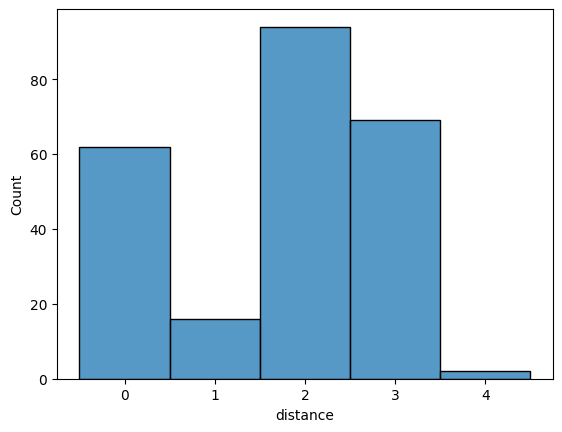

In [21]:
sns.histplot(data=s_overlap_df.iloc[s_overlap_df.groupby('index').distance.idxmin()],x='distance',discrete=True)

<Axes: xlabel='distance', ylabel='Count'>

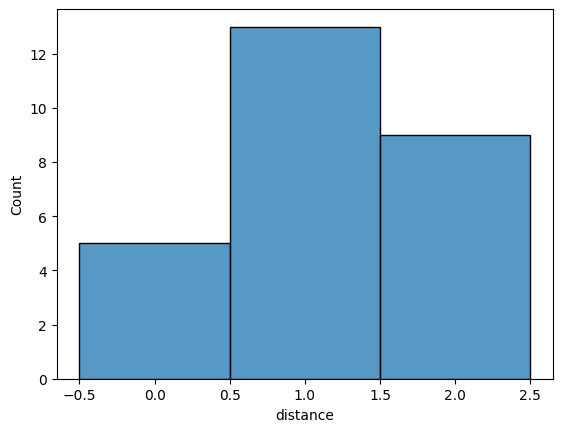

In [22]:
sns.histplot(data=a_overlap_df.iloc[a_overlap_df.groupby('index').distance.idxmin()],x='distance',discrete=True)

## Mean distance

<Axes: xlabel='distance', ylabel='Count'>

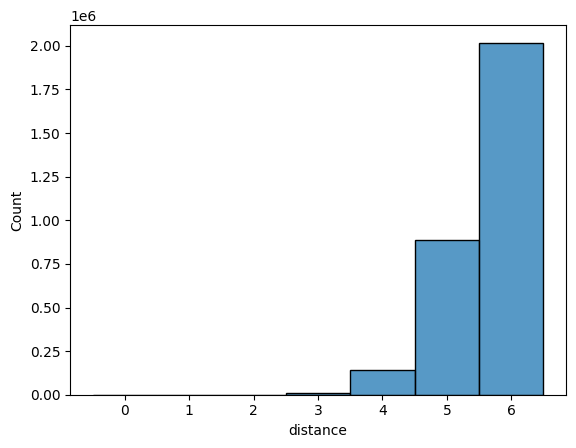

In [23]:
sns.histplot(data=s_overlap_df,x='distance',discrete=True)

<Axes: xlabel='distance', ylabel='Count'>

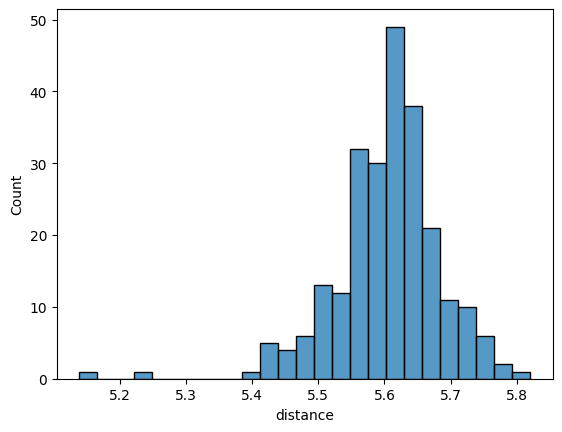

In [24]:
sns.histplot(data=s_overlap_df.groupby('index').distance.mean().reset_index(),x='distance')

<Axes: xlabel='distance', ylabel='Count'>

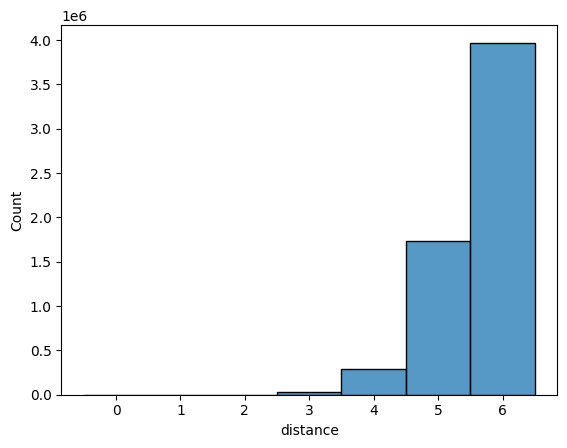

In [25]:
sns.histplot(data=a_overlap_df,x='distance',discrete=True)

<Axes: xlabel='distance', ylabel='Count'>

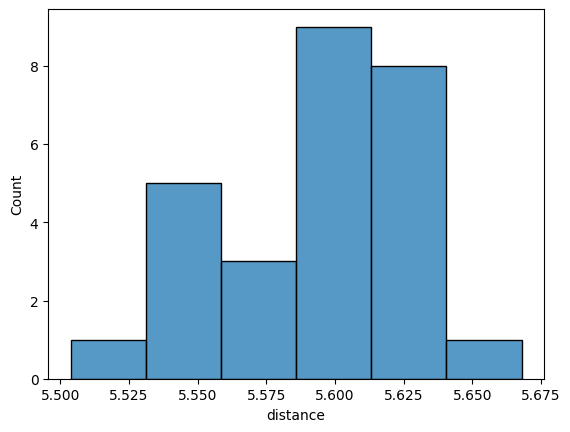

In [26]:
sns.histplot(data=a_overlap_df.groupby('index').distance.mean().reset_index(),x='distance')

# Overlap between waltz and serrano

In [20]:
s_overlap_df[s_overlap_df['distance']==0].drop_duplicates(subset='sequence')

,sequence,value_bool,dataset,sequence_length,index,kmer_index,kmer_seq,waltz_index,waltz_seq,distance
7665,PGGGKVQIVYKPV,1,serrano_s1,13,0,5,VQIVYK,670,VQIVYK,0
37407,PGGGKVQIVEKPV,0,serrano_s1,13,3,5,VQIVEK,1033,VQIVEK,0
188136,NLKHQPGGGKVQIVYKPVDLSKVTSKCGSLGNIHHKPGGGQVE,1,serrano_s1,43,8,10,VQIVYK,670,VQIVYK,0
286066,NLKHQPGGGKVQIVYKEVD,1,serrano_s1,19,13,10,VQIVYK,670,VQIVYK,0
356016,GKVQIVYK,1,serrano_s1,8,16,2,VQIVYK,670,VQIVYK,0
...,...,...,...,...,...,...,...,...,...,...
3021900,YLLYYTEFTP,1,serrano_s2,10,243,0,YLLYYT,60,YLLYYT,0
3029256,TEFTPTEKDE,1,serrano_s2,10,244,0,TEFTPT,421,TEFTPT,0
3038541,TEKDEYACRV,0,serrano_s2,10,245,1,EKDEYA,1312,EKDEYA,0
3048328,YACRVNHVTL,0,serrano_s2,10,246,3,RVNHVT,1306,RVNHVT,0


# Overlap between waltz and amypro

In [27]:
a_overlap_df[a_overlap_df['distance']==0]

,index,kmer_index,kmer_seq,waltz_index,distance
750648,3,41,NFGSVQ,784,0
1711649,8,45,GNVCIN,672,0
1901977,10,55,GNVAVA,736,0
2053688,11,55,IFQINS,1355,0
3395767,17,12,GGVLVN,394,0


In [28]:
waltz_df.iloc[784].value_bool

True

In [15]:
print('amypro_kmer waltz amypro_labels waltz_label amypro_name')
for i,row in a_overlap_df[a_overlap_df['distance']==0].iterrows():
    print(row['kmer_seq'],
          amypro_df.iloc[row['index']].sequence[row['kmer_index']:row['kmer_index']+6],
          amypro_df.iloc[row['index']].res_value_bool[row['kmer_index']:row['kmer_index']+6],
          waltz_df.iloc[row['waltz_index']].value_bool,
          amypro_df.iloc[row['index']]['name'])
    

amypro_kmer waltz amypro_labels waltz_label amypro_name
NFGSVQ NFGSVQ 111111 True  Medin__AP00018
GNVCIN GNVCIN 110000 True  Chaplin_H__AP00039
GNVAVA GNVAVA 111111 True  Chorion_class_A_protein_PC292__AP00046
IFQINS IFQINS 111111 True  Lysozyme_C__AP00016
GGVLVN GGVLVN 011111 True  PAPf39__AP00091


Looks like these are real overlap

## Verify the sequence names

In [9]:
a_overlap_df[a_overlap_df['distance']==0]

,index,kmer_index,kmer_seq,waltz_index,distance
750648,3,41,NFGSVQ,784,0
1711649,8,45,GNVCIN,672,0
1901977,10,55,GNVAVA,736,0
2053688,11,55,IFQINS,1355,0
3395767,17,12,GGVLVN,394,0


In [13]:
amypro_df.loc[a_overlap_df[a_overlap_df['distance']==0]['index']]

,name,sequence,res_value_bool,dataset,value_bool,len
3,Medin__AP00018,RLDKQGNFNAWVAGSYGNDQWLQVDLGSSKEVTGIITQGARNFGSV...,0000000000000000000000000000000111111111111111...,amypro27,1,50
8,Chaplin_H__AP00039,DSGAQGAAVHSPGVLSGNVVQVPVHVPVNVCGNTISVIGLLNPAFG...,0000000000001111111111111111100111111111111111...,amypro27,1,52
10,Chorion_class_A_protein_PC292__AP00046,VCRGGLGLKGLAAPACGCGGLGYEGLGYGALGYDGLGYGAGWAGPA...,0000000000000000000000000000000000000000000000...,amypro27,1,113
11,Lysozyme_C__AP00016,KVFERCELARTLKRLGMDGYRGISLANWMCLAKWESGYNTRATNYN...,0000111111111100000000001111111111000000000000...,amypro27,1,130
17,PAPf39__AP00091,GIHKQKEKSRLQGGVLVNEILNHMKRATQIPSYKKLIMY,000000000000011111111111111111111111111,amypro27,1,39


In [ ]:
print('amypro_kmer waltz amypro_labels waltz_label')
for i,row in a_overlap_df[a_overlap_df['distance']==0].iterrows():
    print(row['kmer_seq'],
          amypro_df.iloc[row['index']].sequence[row['kmer_index']:row['kmer_index']+6],
          amypro_df.iloc[row['index']].res_value_bool[row['kmer_index']:row['kmer_index']+6],
          waltz_df.iloc[row['waltz_index']].value_bool)

## Create new dataset

In [9]:
a_overlap_df[a_overlap_df['distance']==0]['index'].unique()

array([ 3,  8, 10, 11, 17])

In [11]:
amypro_df[amypro_df.index.isin(a_overlap_df[a_overlap_df['distance']==0]['index'].unique())]

,name,sequence,res_value_bool,dataset,value_bool,len
3,Medin__AP00018,RLDKQGNFNAWVAGSYGNDQWLQVDLGSSKEVTGIITQGARNFGSV...,0000000000000000000000000000000111111111111111...,amypro27,1,50
8,Chaplin_H__AP00039,DSGAQGAAVHSPGVLSGNVVQVPVHVPVNVCGNTISVIGLLNPAFG...,0000000000001111111111111111100111111111111111...,amypro27,1,52
10,Chorion_class_A_protein_PC292__AP00046,VCRGGLGLKGLAAPACGCGGLGYEGLGYGALGYDGLGYGAGWAGPA...,0000000000000000000000000000000000000000000000...,amypro27,1,113
11,Lysozyme_C__AP00016,KVFERCELARTLKRLGMDGYRGISLANWMCLAKWESGYNTRATNYN...,0000111111111100000000001111111111000000000000...,amypro27,1,130
17,PAPf39__AP00091,GIHKQKEKSRLQGGVLVNEILNHMKRATQIPSYKKLIMY,000000000000011111111111111111111111111,amypro27,1,39


In [16]:
print(len(amypro_df))
filt_amypro_df = amypro_df[~amypro_df.index.isin(a_overlap_df[a_overlap_df['distance']==0]['index'].unique())].reset_index(drop=True)
print(len(filt_amypro_df))
filt_amypro_df.to_csv('tables/250211_amypro22_filteredwaltzhits.csv')

27
22
